In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [27]:
df = pd.read_csv('../data/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [28]:
df.shape

(2200, 8)

In [29]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


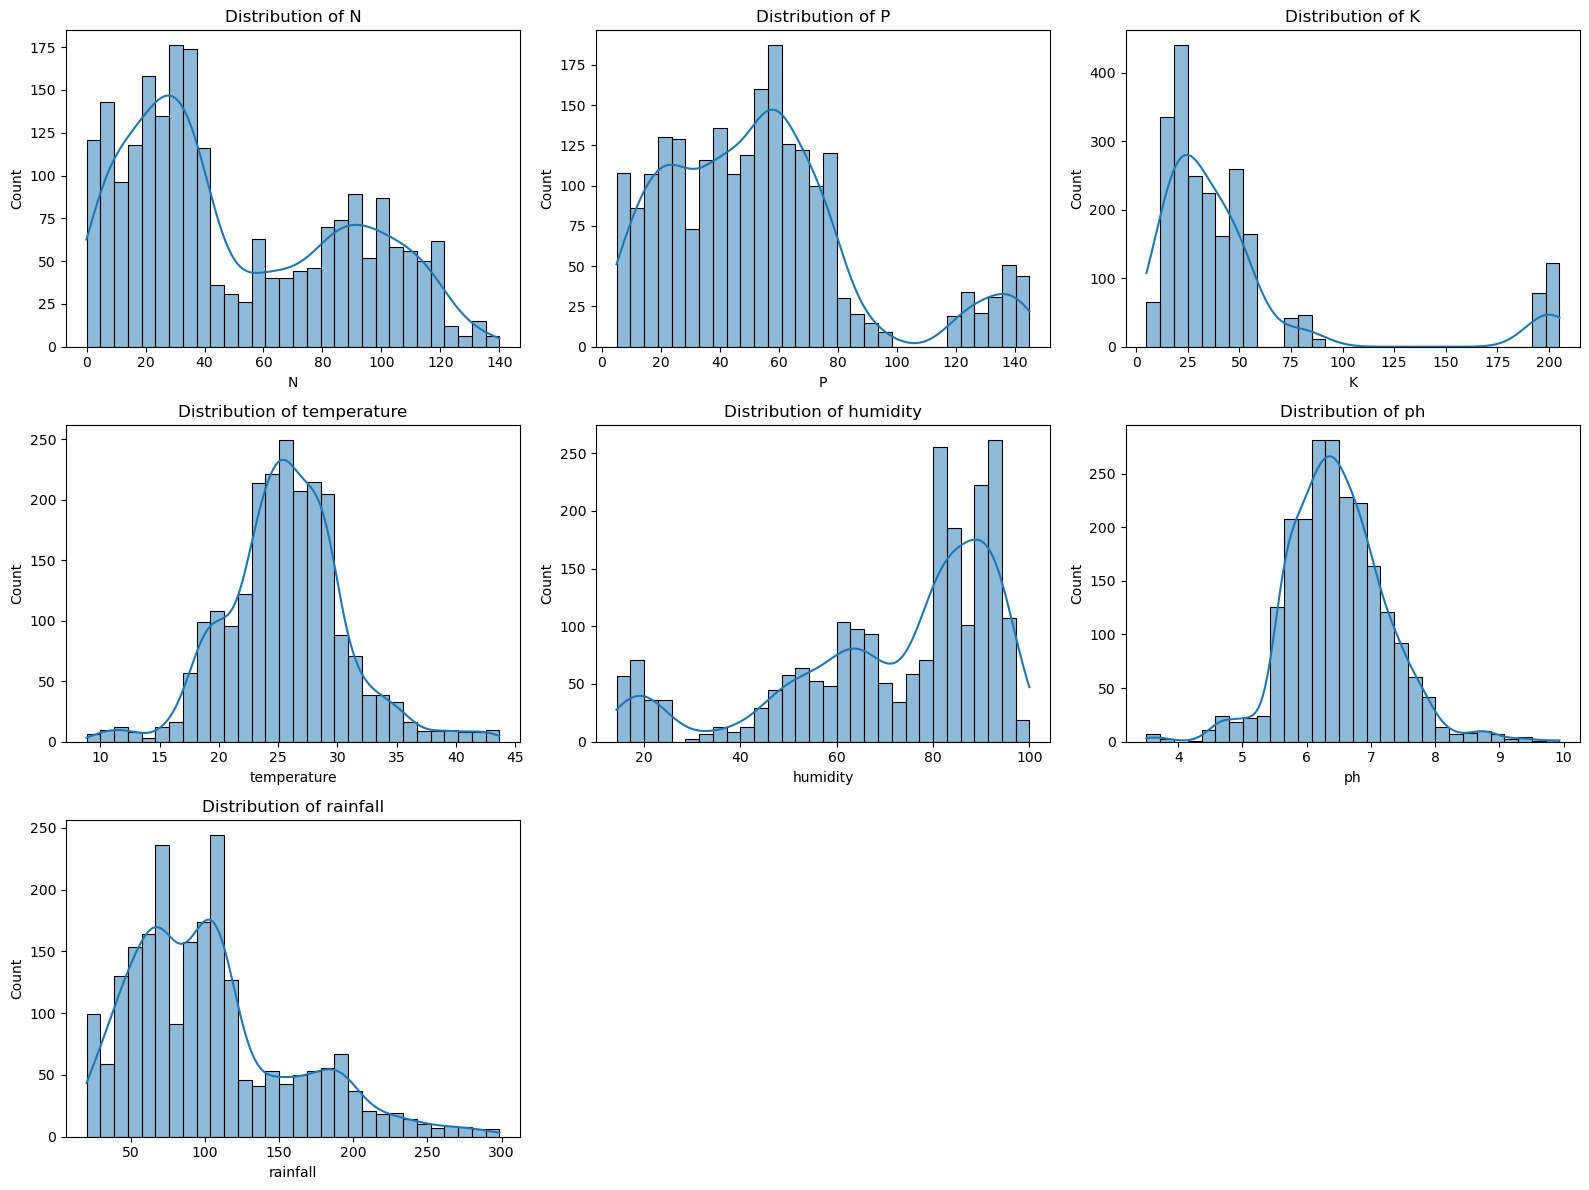

In [30]:
feature_columns = df.columns[:-1]

plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### 🔍 Outlier Detection Analysis
Identifying outliers in our dataset using box plots for each feature.

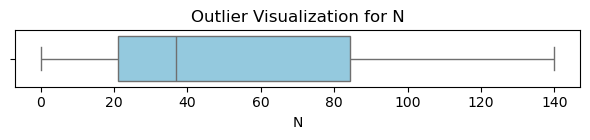

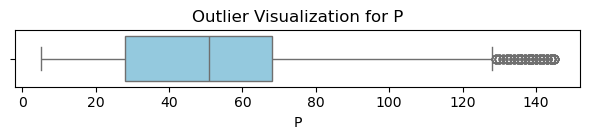

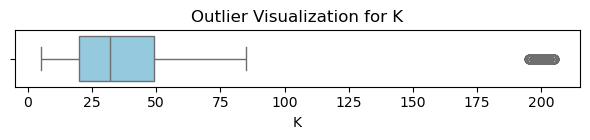

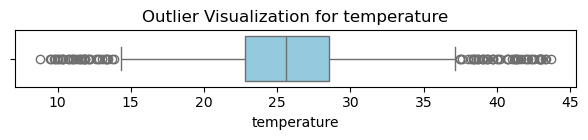

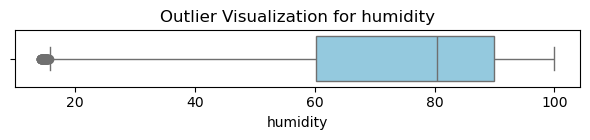

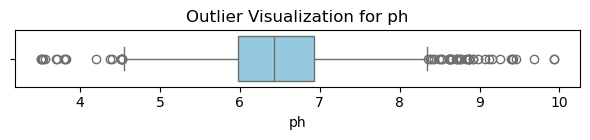

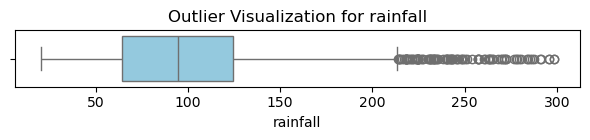

In [31]:
for col in feature_columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Outlier Visualization for {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [32]:
# Remove outliers from all feature columns using the IQR method
def remove_outliers_iqr(df, feature_columns):
    df_clean = df.copy()
    for col in feature_columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

df_no_outliers = remove_outliers_iqr(df, feature_columns)
df_no_outliers.shape

(1846, 8)

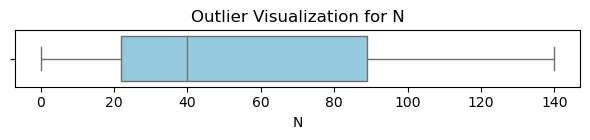

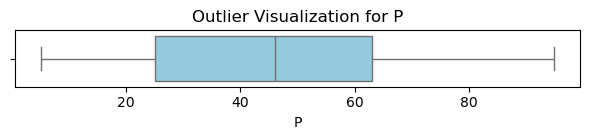

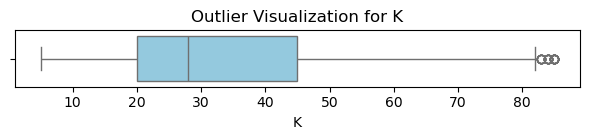

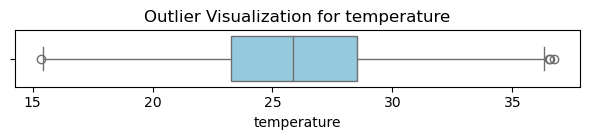

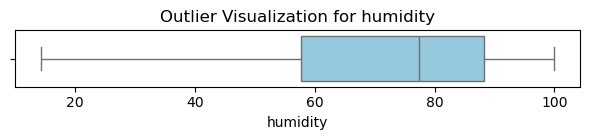

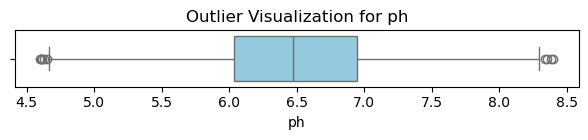

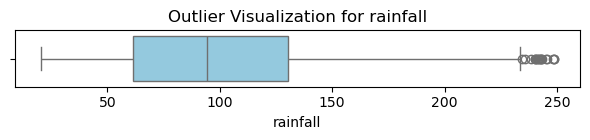

In [33]:
for col in feature_columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df_no_outliers[col], color='skyblue')
    plt.title(f'Outlier Visualization for {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### 📊 Updated Feature Distributions
Visualizing cleaned data distributions after outlier removal.

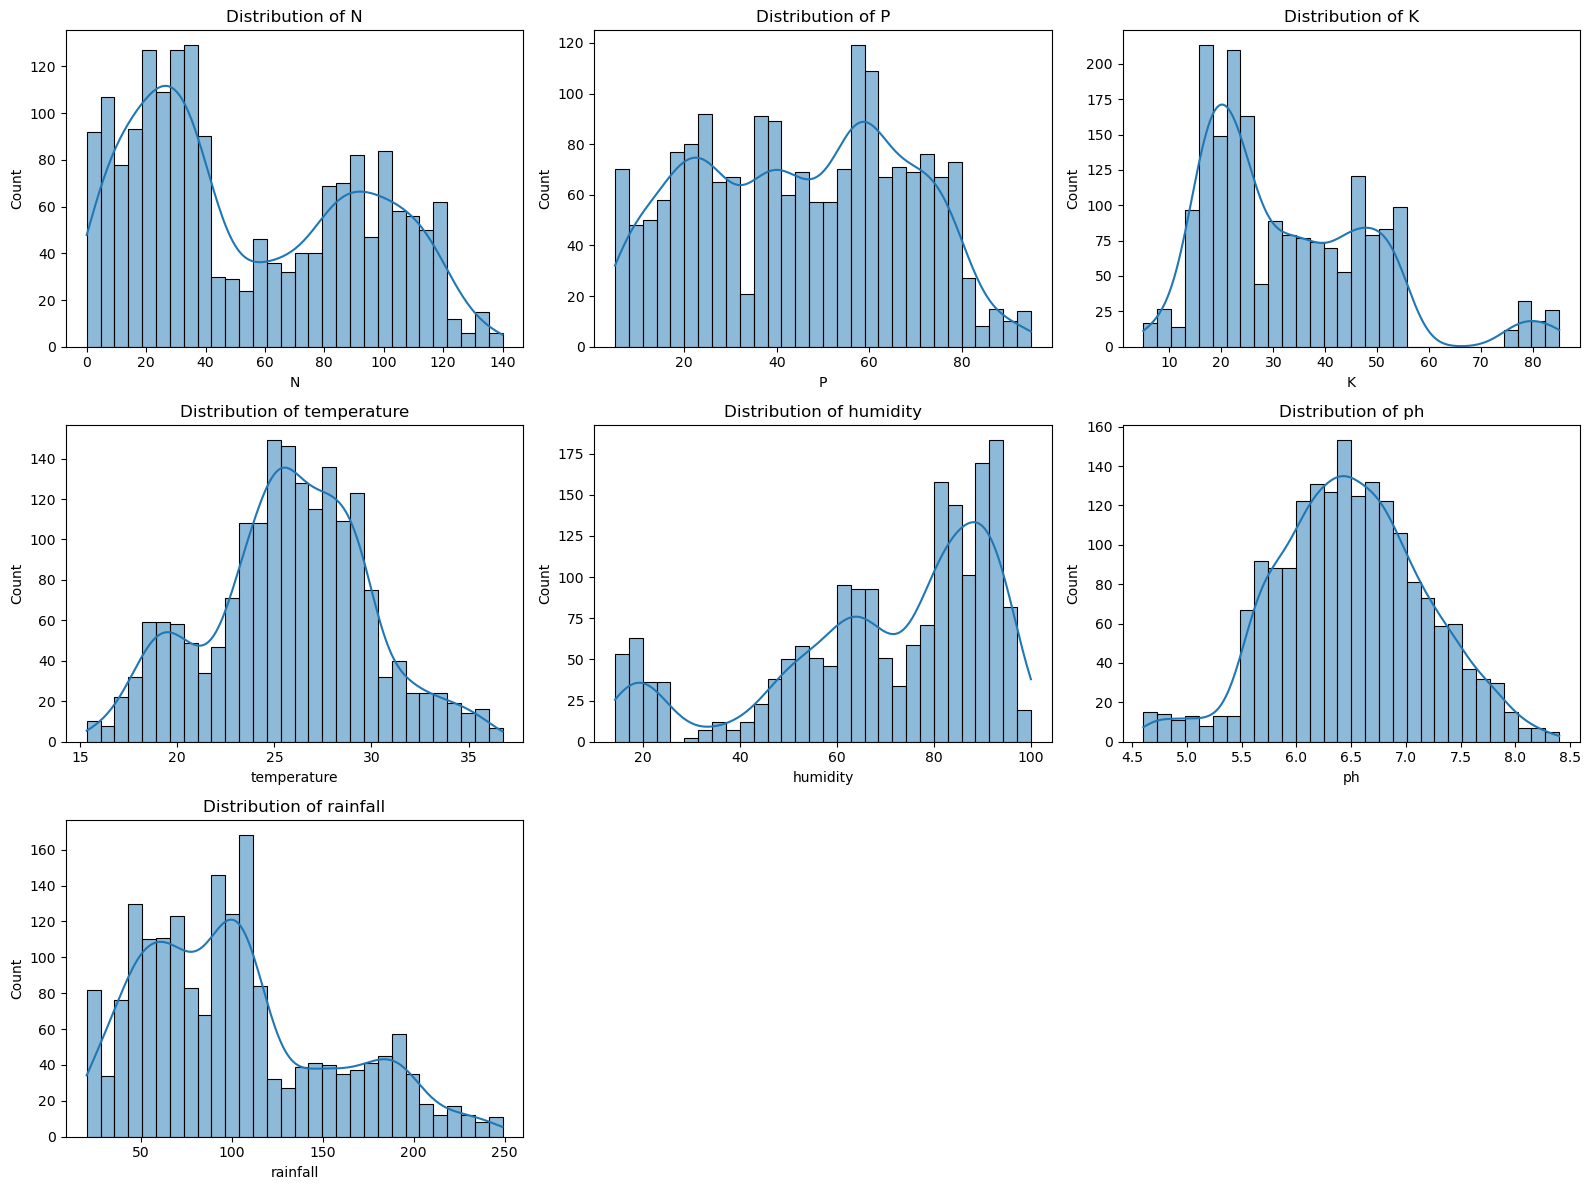

In [34]:
feature_columns = df_no_outliers.columns[:-1]

plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_no_outliers[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [35]:
unique_labels = df_no_outliers['label'].unique()
print("Unique categories in 'label':", unique_labels)

Unique categories in 'label': ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango'
 'watermelon' 'muskmelon' 'orange' 'papaya' 'coconut' 'cotton' 'jute'
 'coffee']


In [36]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Model 1: Random Forest Classifier
print("🌳 Training Random Forest Classifier...")

# Define model with hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Calculate accuracies
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)

print(f"✅ Random Forest Training Complete!")
print(f"   Validation Accuracy: {rf_val_accuracy:.4f}")
print(f"   Test Accuracy: {rf_test_accuracy:.4f}")

# Save the model
joblib.dump(rf_model, '../models/random_forest_model.pkl')
print(f"💾 Model saved as 'random_forest_model.pkl'")

🌳 Training Random Forest Classifier...


✅ Random Forest Training Complete!
   Validation Accuracy: 0.9964
   Test Accuracy: 1.0000
💾 Model saved as 'random_forest_model.pkl'


### 🚀 Model 2: XGBoost Classifier

**XGBoost Advantages:**
- State-of-the-art gradient boosting
- Superior performance on tabular data
- Built-in regularization
- Efficient parallel processing

**Hyperparameters:**
- `n_estimators=100`: Number of boosting rounds
- `max_depth=6`: Maximum tree depth
- `learning_rate=0.1`: Step size shrinkage
- `subsample=0.8`: Fraction of samples per tree

In [39]:
# Model 2: XGBoost Classifier
print("🚀 Training XGBoost Classifier...")

# Define model with hyperparameters
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate accuracies
xgb_val_accuracy = accuracy_score(y_val, xgb_val_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)

print(f"✅ XGBoost Training Complete!")
print(f"   Validation Accuracy: {xgb_val_accuracy:.4f}")
print(f"   Test Accuracy: {xgb_test_accuracy:.4f}")

# Save the model
joblib.dump(xgb_model, '../models/xgboost_model.pkl')
print(f"💾 Model saved as 'xgboost_model.pkl'")

🚀 Training XGBoost Classifier...
✅ XGBoost Training Complete!
   Validation Accuracy: 0.9964
   Test Accuracy: 0.9892
💾 Model saved as 'xgboost_model.pkl'
✅ XGBoost Training Complete!
   Validation Accuracy: 0.9964
   Test Accuracy: 0.9892
💾 Model saved as 'xgboost_model.pkl'


### 🔧 Model 3: Support Vector Machine

**Template for adding new models:**
Copy this cell and modify the model definition to add new algorithms like SVM, Logistic Regression, etc.

In [40]:
# Model 3: Support Vector Machine (Example)
# Uncomment and modify this section to add SVM

from sklearn.svm import SVC

print("🔧 Training Support Vector Machine...")

# Define model with hyperparameters
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_val_pred = svm_model.predict(X_val)
svm_test_pred = svm_model.predict(X_test)

# Calculate accuracies
svm_val_accuracy = accuracy_score(y_val, svm_val_pred)
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)

print(f"✅ SVM Training Complete!")
print(f"   Validation Accuracy: {svm_val_accuracy:.4f}")
print(f"   Test Accuracy: {svm_test_accuracy:.4f}")

# Save the model
joblib.dump(svm_model, '../models/svm_model.pkl')
print(f"💾 Model saved as 'svm_model.pkl'")

🔧 Training Support Vector Machine...


✅ SVM Training Complete!
   Validation Accuracy: 0.9675
   Test Accuracy: 0.9675
💾 Model saved as 'svm_model.pkl'


In [41]:
# Collect all trained models and their performance
models_performance = {
    'Random Forest': {
        'model': rf_model,
        'val_accuracy': rf_val_accuracy,
        'test_accuracy': rf_test_accuracy,
        'val_pred': rf_val_pred,
        'test_pred': rf_test_pred
    },
    'XGBoost': {
        'model': xgb_model,
        'val_accuracy': xgb_val_accuracy,
        'test_accuracy': xgb_test_accuracy,
        'val_pred': xgb_val_pred,
        'test_pred': xgb_test_pred
    },
    # Add more models here as you train them
    'SVM': {
        'model': svm_model,
        'val_accuracy': svm_val_accuracy,
        'test_accuracy': svm_test_accuracy,
        'val_pred': svm_val_pred,
        'test_pred': svm_test_pred
    }
}

# Extract model information for comparison
model_names = list(models_performance.keys())
val_accuracies = [models_performance[name]['val_accuracy'] for name in model_names]
test_accuracies = [models_performance[name]['test_accuracy'] for name in model_names]

print("Models collected for comparison:")
for name in model_names:
    print(f"- {name}")

Models collected for comparison:
- Random Forest
- XGBoost
- SVM


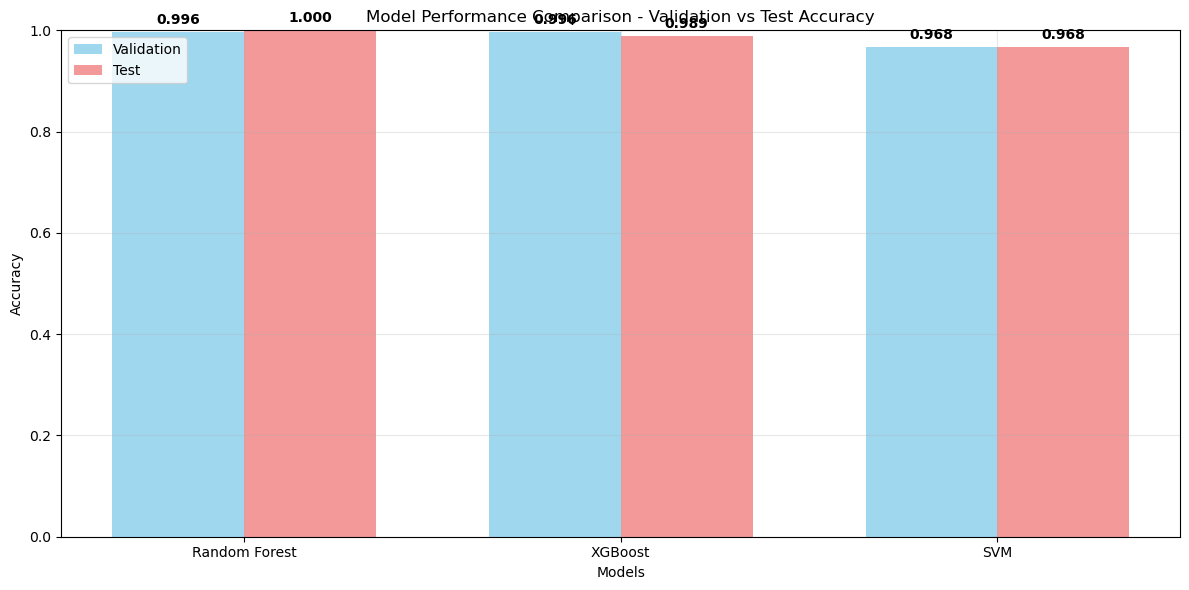


Overfitting Analysis (Validation - Test Accuracy):
Random Forest: -0.0036 (Low overfitting)
XGBoost: 0.0072 (Low overfitting)
SVM: 0.0000 (Low overfitting)


In [51]:
# Visualization 1: Model Performance Comparison Bar Chart
plt.figure(figsize=(12, 6))

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='skyblue')
plt.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.8, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison - Validation vs Test Accuracy')
plt.xticks(x, model_names)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for i, (val_acc, test_acc) in enumerate(zip(val_accuracies, test_accuracies)):
    plt.text(i - width/2, val_acc + 0.01, f'{val_acc:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print accuracy differences (overfitting analysis)
print("\nOverfitting Analysis (Validation - Test Accuracy):")
for i, model_name in enumerate(model_names):
    diff = val_accuracies[i] - test_accuracies[i]
    status = 'Low' if abs(diff) < 0.02 else 'Moderate' if abs(diff) < 0.05 else 'High'
    print(f"{model_name}: {diff:.4f} ({status} overfitting)")

### 📈 Visualization 2: Feature Importance Analysis
Understanding which features contribute most to the Random Forest model's predictions.

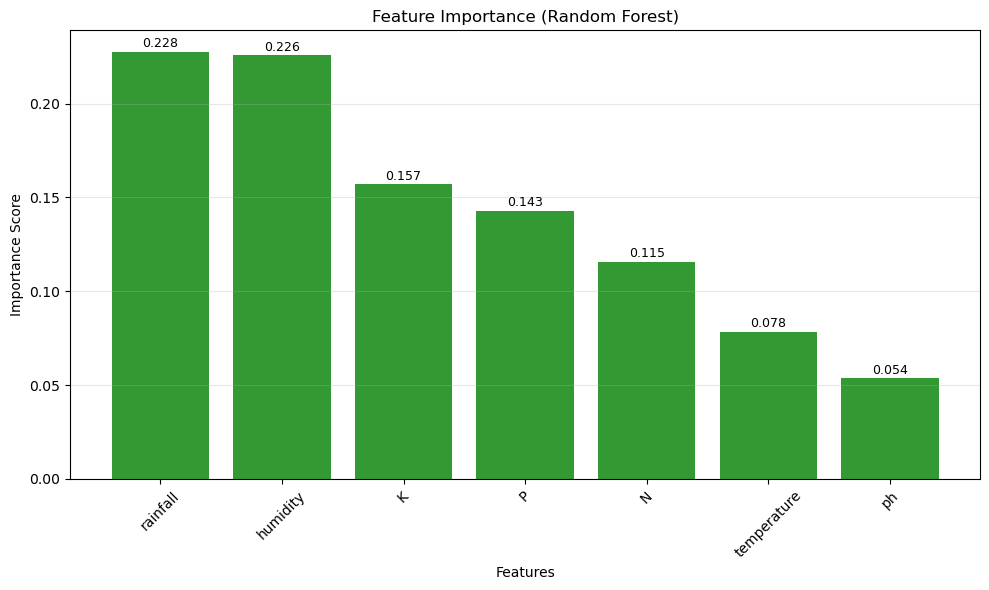


Feature Importance Rankings (Random Forest):
1. rainfall: 0.2276
2. humidity: 0.2256
3. K: 0.1569
4. P: 0.1428
5. N: 0.1155
6. temperature: 0.0781
7. ph: 0.0535


In [43]:
# Visualization 2: Feature Importance for Random Forest
feature_importance_rf = rf_model.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(feature_importance_rf)[::-1]
sorted_importance = feature_importance_rf[indices]
sorted_features = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_importance_rf)), sorted_importance, alpha=0.8, color='green')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.xticks(range(len(feature_importance_rf)), sorted_features, rotation=45)

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{importance:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nFeature Importance Rankings (Random Forest):")
for i, (feature, importance) in enumerate(zip(sorted_features, sorted_importance)):
    print(f"{i+1}. {feature}: {importance:.4f}")

### 🎯 Visualization 3: Model Accuracy Line Plot
Trend analysis showing how different models perform across validation and test sets.

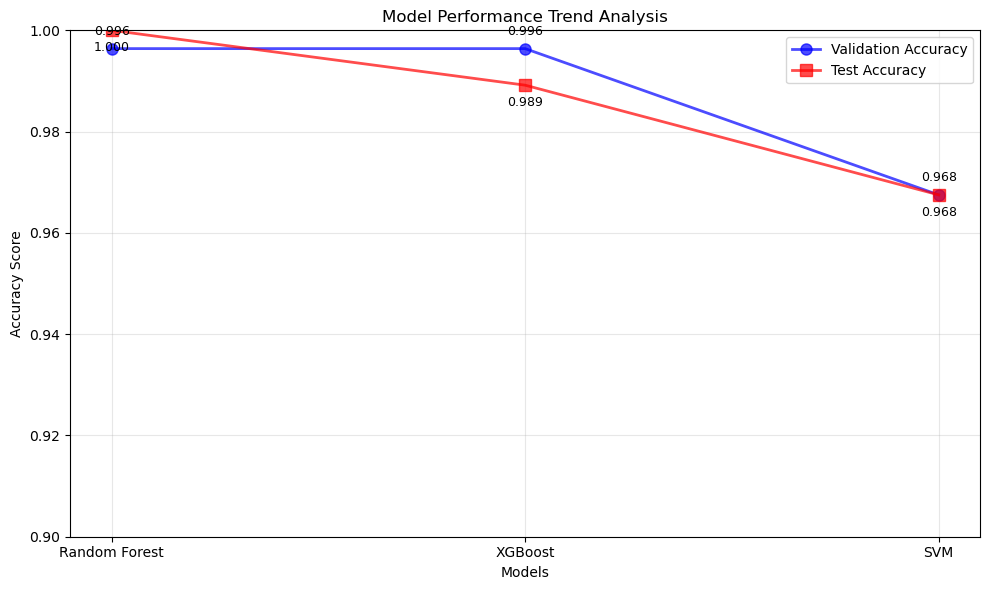

In [44]:
# Visualization 3: Model Accuracy Line Plot
plt.figure(figsize=(10, 6))

x_pos = range(len(model_names))
plt.plot(x_pos, val_accuracies, marker='o', linewidth=2, markersize=8, 
         label='Validation Accuracy', color='blue', alpha=0.7)
plt.plot(x_pos, test_accuracies, marker='s', linewidth=2, markersize=8, 
         label='Test Accuracy', color='red', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Trend Analysis')
plt.xticks(x_pos, model_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.9, 1.0)  # Adjust based on your accuracy range

# Add value annotations
for i, (val_acc, test_acc) in enumerate(zip(val_accuracies, test_accuracies)):
    plt.annotate(f'{val_acc:.3f}', (i, val_acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'{test_acc:.3f}', (i, test_acc), textcoords="offset points", 
                xytext=(0,-15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### 📈 Visualization 5: Performance Summary Table
Comprehensive performance metrics table for all models.

In [46]:
# Visualization 5: Performance Summary Table
import pandas as pd

# Create comprehensive performance dataframe
performance_data = {
    'Model': model_names,
    'Validation Accuracy': [f"{acc:.4f}" for acc in val_accuracies],
    'Test Accuracy': [f"{acc:.4f}" for acc in test_accuracies],
    'Accuracy Difference': [f"{val_accuracies[i] - test_accuracies[i]:.4f}" for i in range(len(model_names))],
    'Consistency Score': [f"{1 - abs(val_accuracies[i] - test_accuracies[i]):.4f}" for i in range(len(model_names))],
    'Overfitting Status': [
        'Low' if abs(val_accuracies[i] - test_accuracies[i]) < 0.02 
        else 'Moderate' if abs(val_accuracies[i] - test_accuracies[i]) < 0.05 
        else 'High' for i in range(len(model_names))
    ]
}

performance_df = pd.DataFrame(performance_data)

# Display as styled table
print("📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(performance_df.to_string(index=False))

# Determine best model
best_model_idx = np.argmax(test_accuracies)
best_model_name = model_names[best_model_idx]
best_accuracy = test_accuracies[best_model_idx]

print(f"\n🏆 BEST PERFORMING MODEL")
print("=" * 30)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracies[best_model_idx]:.4f}")
print(f"Overfitting: {performance_data['Overfitting Status'][best_model_idx]}")

📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY
        Model Validation Accuracy Test Accuracy Accuracy Difference Consistency Score Overfitting Status
Random Forest              0.9964        1.0000             -0.0036            0.9964                Low
      XGBoost              0.9964        0.9892              0.0072            0.9928                Low
          SVM              0.9675        0.9675              0.0000            1.0000                Low

🏆 BEST PERFORMING MODEL
Model: Random Forest
Test Accuracy: 1.0000 (100.00%)
Validation Accuracy: 0.9964
Overfitting: Low


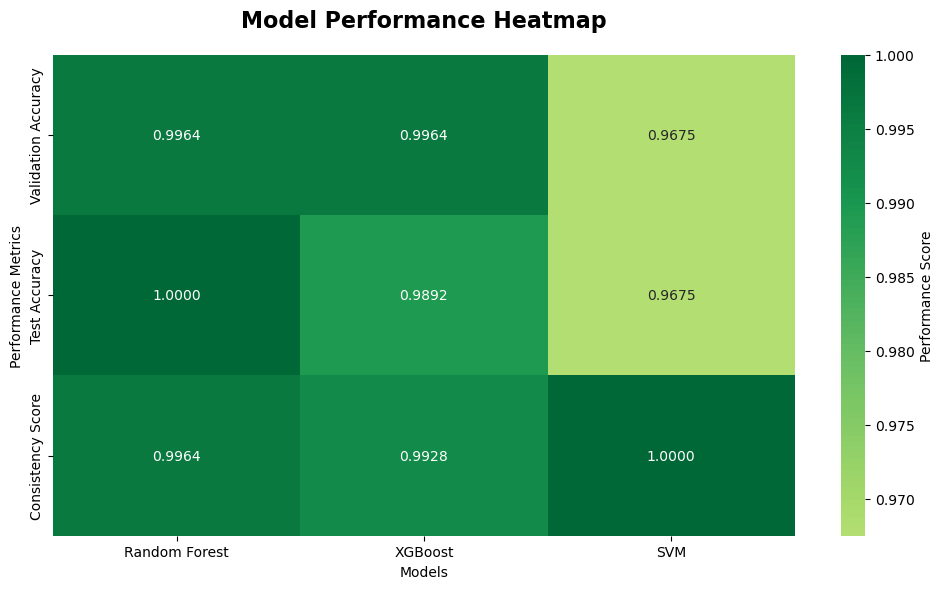

📈 Heatmap Interpretation:
- Green: Better performance
- Yellow: Average performance
- Red: Lower performance
- Consistency Score = 1 - |Validation Accuracy - Test Accuracy|


In [47]:
# Visualization 6: Model Performance Heatmap
# Prepare data matrix for heatmap
metrics_matrix = np.array([
    val_accuracies,
    test_accuracies,
    [1 - abs(val_accuracies[i] - test_accuracies[i]) for i in range(len(model_names))]
])

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_matrix, 
            xticklabels=model_names,
            yticklabels=['Validation Accuracy', 'Test Accuracy', 'Consistency Score'],
            annot=True, 
            fmt='.4f',
            cmap='RdYlGn',
            center=0.95,
            cbar_kws={'label': 'Performance Score'})

plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Models')
plt.ylabel('Performance Metrics')
plt.tight_layout()
plt.show()

print("📈 Heatmap Interpretation:")
print("- Green: Better performance")
print("- Yellow: Average performance") 
print("- Red: Lower performance")
print("- Consistency Score = 1 - |Validation Accuracy - Test Accuracy|")

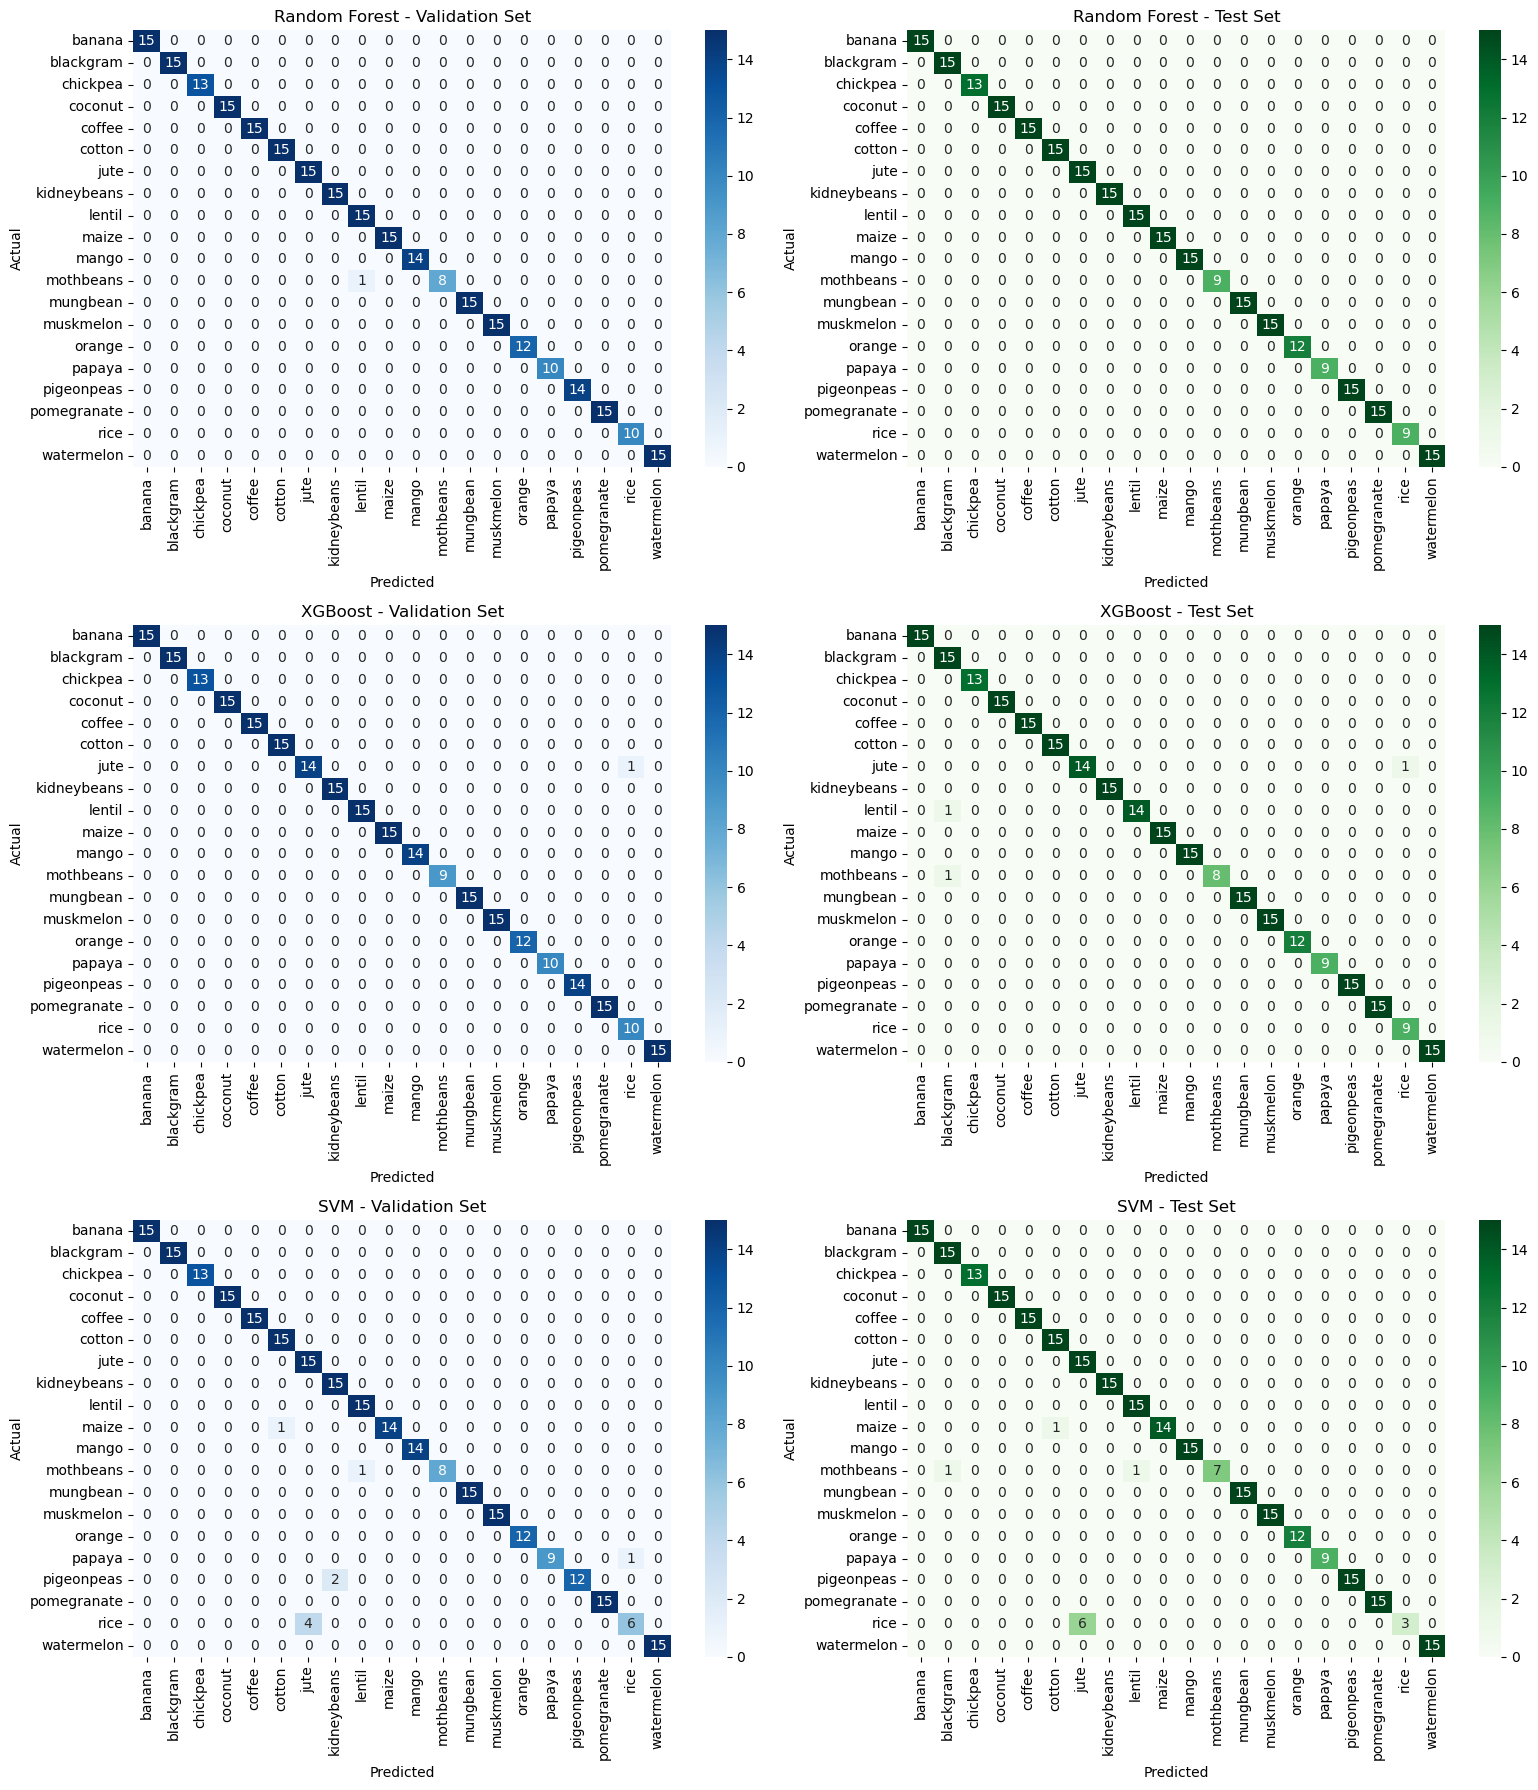

In [48]:
# Create confusion matrices for all models
num_models = len(models_performance)
fig, axes = plt.subplots(num_models, 2, figsize=(16, 6*num_models))

if num_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, performance) in enumerate(models_performance.items()):
    # Validation confusion matrix
    val_cm = confusion_matrix(y_val, performance['val_pred'])
    test_cm = confusion_matrix(y_test, performance['test_pred'])
    
    # Plot validation confusion matrix
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx, 0],
                xticklabels=label_encoder.classes_[:len(np.unique(y_val))], 
                yticklabels=label_encoder.classes_[:len(np.unique(y_val))])
    axes[idx, 0].set_title(f'{model_name} - Validation Set')
    axes[idx, 0].set_xlabel('Predicted')
    axes[idx, 0].set_ylabel('Actual')
    
    # Plot test confusion matrix
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx, 1],
                xticklabels=label_encoder.classes_[:len(np.unique(y_test))], 
                yticklabels=label_encoder.classes_[:len(np.unique(y_test))])
    axes[idx, 1].set_title(f'{model_name} - Test Set')
    axes[idx, 1].set_xlabel('Predicted')
    axes[idx, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [49]:
# Classification Reports for all models
print("="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for model_name, performance in models_performance.items():
    print(f"\n{'='*30}")
    print(f"{model_name.upper()} - TEST SET")
    print("="*30)
    print(classification_report(y_test, performance['test_pred'], target_names=label_encoder.classes_))

# Final Model Comparison Summary
print("\n" + "="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

comparison_data = {
    'Model': model_names,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies,
    'Difference (Val-Test)': [val - test for val, test in zip(val_accuracies, test_accuracies)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

# Determine the best model
best_model_idx = np.argmax(test_accuracies)
best_model_name = model_names[best_model_idx]
best_accuracy = test_accuracies[best_model_idx]

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"📊 Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Check for overfitting
print(f"\n📈 Overfitting Analysis:")
for i, model_name in enumerate(model_names):
    overfitting = val_accuracies[i] - test_accuracies[i]
    status = 'Low' if abs(overfitting) < 0.02 else 'Moderate' if abs(overfitting) < 0.05 else 'High'
    print(f"{model_name}: {overfitting:.4f} ({status} overfitting)")

DETAILED CLASSIFICATION REPORTS

RANDOM FOREST - TEST SET
              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        15
   blackgram       1.00      1.00      1.00        15
    chickpea       1.00      1.00      1.00        13
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
        jute       1.00      1.00      1.00        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      1.00      1.00        15
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00         9
    mungbean       1.00      1.00      1.00        15
   muskmelon       1.00      1.00      1.00        15
      orange       1.00      1.00      1.00        12
      papaya       1.00      1.00      1.00         9
  pigeonpeas       1.00

In [50]:
# Load the best performing model for prediction
best_model = models_performance[best_model_name]['model']

# Example input: replace these values with your own test data
# Order: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
input_features = np.array([[61, 68, 50, 35.21462816, 91.49725058, 6.7932454170000005, 243.0745066]])

print("🔮 Making Predictions with Trained Models")
print("="*50)

# Predict using all trained models
for model_name, performance in models_performance.items():
    model = performance['model']
    pred = model.predict(input_features)
    predicted_label = label_encoder.inverse_transform(pred)[0]
    
    # Get prediction probability if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(input_features)[0]
        confidence = np.max(probabilities)
        print(f"{model_name:15}: {predicted_label:12} (Confidence: {confidence:.3f})")
    else:
        print(f"{model_name:15}: {predicted_label}")

print(f"\n✅ Recommended crop: {best_model_name} suggests '{label_encoder.inverse_transform(best_model.predict(input_features))[0]}'")

🔮 Making Predictions with Trained Models
Random Forest  : papaya       (Confidence: 0.942)
XGBoost        : papaya       (Confidence: 0.990)
SVM            : papaya

✅ Recommended crop: Random Forest suggests 'papaya'
